In [11]:
"""
-------------------------------------------------------------
Rôle du Modèle ML dans AirAware 
-------------------------------------------------------------
Le modèle de Machine Learning (Random Forest) prédit si la 
pièce est occupée à partir des mesures CO2, Humidité, 
Température, Lumière et HumidityRatio.

Cette prédiction rend AirAware plus intelligent en permettant :
- d’ajuster automatiquement la ventilation selon la présence,
- d’améliorer la précision des analyses de qualité d’air,
- d’envoyer des alertes pertinentes (ex : CO2 élevé + salle occupée),
- d’automatiser les actions sur Raspberry Pi en temps réel.

En résumé, le modèle ML ajoute une couche d’intelligence qui 
optimise la gestion de l’air selon l’usage réel de la pièce.
-------------------------------------------------------------
"""

'\n-------------------------------------------------------------\nRôle du Modèle ML dans AirAware \n-------------------------------------------------------------\nLe modèle de Machine Learning (Random Forest) prédit si la \npièce est occupée à partir des mesures CO2, Humidité, \nTempérature, Lumière et HumidityRatio.\n\nCette prédiction rend AirAware plus intelligent en permettant :\n- d’ajuster automatiquement la ventilation selon la présence,\n- d’améliorer la précision des analyses de qualité d’air,\n- d’envoyer des alertes pertinentes (ex : CO2 élevé + salle occupée),\n- d’automatiser les actions sur Raspberry Pi en temps réel.\n\nEn résumé, le modèle ML ajoute une couche d’intelligence qui \noptimise la gestion de l’air selon l’usage réel de la pièce.\n-------------------------------------------------------------\n'

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des fichiers à charger. Les noms correspondent à l'image fournie.
files = {
    'train': 'datatraining.txt',
    'test1': 'datatest.txt',
    'test2': 'datatest2.txt'
}

def load_and_prepare_df(file_path):
    """Charge un fichier, définit l'index temporel et supprime la colonne inutile."""
    df = pd.read_csv(file_path, sep=",")
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

# Chargement des trois datasets
df_train = load_and_prepare_df(files['train'])
df_test1 = load_and_prepare_df(files['test1'])
df_test2 = load_and_prepare_df(files['test2'])

# Combinaison des deux jeux de test pour une évaluation plus large
df_test = pd.concat([df_test1, df_test2])

print(f"✅ Chargement terminé.")
print(f"Dataset Entraînement (df_train) : {df_train.shape[0]} lignes")
print(f"Dataset Test Combiné (df_test) : {df_test.shape[0]} lignes")

✅ Chargement terminé.
Dataset Entraînement (df_train) : 8143 lignes
Dataset Test Combiné (df_test) : 12417 lignes



⏳ Entraînement du modèle Random Forest sur datatraining.txt...
✅ Modèle entraîné avec succès.


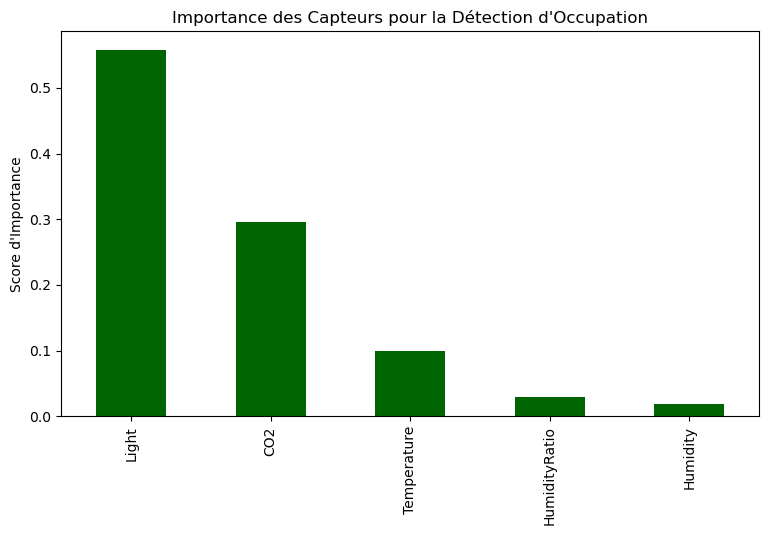

In [5]:
# Variables Prédictives (X) correspondant à vos capteurs (BME680, SGP30, MH-Z19)
# La colonne 'Light' est un excellent prédicteur pour la détection d'occupation.
features = ['Temperature', 'Humidity', 'CO2', 'Light', 'HumidityRatio'] 

# Séparation des features et de la cible pour l'entraînement
X_train = df_train[features]
y_train = df_train['Occupancy']

# Création et entraînement du modèle 
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\n⏳ Entraînement du modèle Random Forest sur datatraining.txt...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès.")

# Importance des variables
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(9, 5))
importances.plot(kind='bar', color='darkgreen')
plt.title("Importance des Capteurs pour la Détection d'Occupation")
plt.ylabel("Score d'Importance")
plt.show()


--- Évaluation du Modèle sur les Jeux de Test (datatest.txt + datatest2.txt) ---
Accuracy (Précision Globale) : 0.9482966900217444

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      9396
           1       0.92      0.87      0.89      3021

    accuracy                           0.95     12417
   macro avg       0.94      0.92      0.93     12417
weighted avg       0.95      0.95      0.95     12417



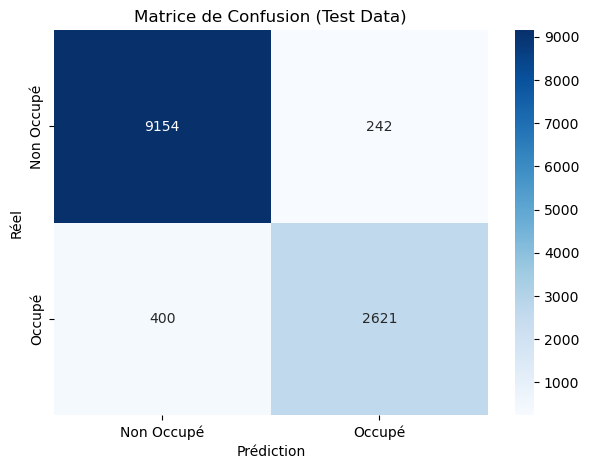


✅ Le modèle est sauvegardé pour le déploiement sur votre Raspberry Pi : air_aware_random_forest_occupancy.pkl


In [7]:
# Préparation des données de test
X_test = df_test[features]
y_test = df_test['Occupancy']

# Prédictions
y_pred = model.predict(X_test)

# --- Métriques de Performance ---

print("\n--- Évaluation du Modèle sur les Jeux de Test (datatest.txt + datatest2.txt) ---")
print("Accuracy (Précision Globale) :", accuracy_score(y_test, y_pred))
print("\nRapport de Classification :\n", classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non Occupé', 'Occupé'], 
            yticklabels=['Non Occupé', 'Occupé'])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de Confusion (Test Data)')
plt.show()

# Exportation du modèle pour le MLOps 
model_filename = 'air_aware_random_forest_occupancy.pkl'
joblib.dump(model, model_filename)

print(f"\n✅ Le modèle est sauvegardé pour le déploiement sur votre Raspberry Pi : {model_filename}")